In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Dropout, Conv2D, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [4]:
from tensorflow.keras.datasets import fashion_mnist

In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [6]:
X_train.shape

(60000, 28, 28)

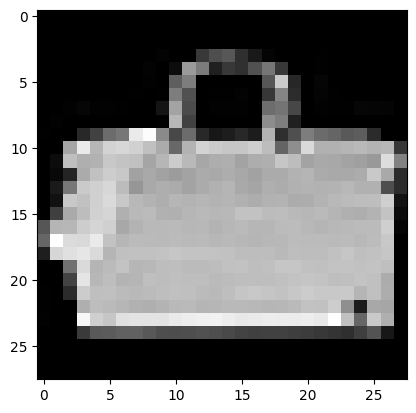

In [7]:
plt.imshow(X_train[99], cmap='gray');

In [8]:
X_train = X_train / 255

In [9]:
X_train = X_train.reshape(-1, 28, 28, 1)

In [10]:
X_train = X_train * 2 - 1

In [11]:
print(X_train.min())
print(X_train.max())

-1.0
1.0


In [12]:
buffer_size = 60000
batch_size = 128
latent_dim = 100
epochs = 50

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

## Generator and Discriminator

In [15]:
generator = Sequential([
    Input(shape=(latent_dim,)),
    Dense(units=7*7*256,use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    
    Reshape((7,7,256)),
    
    Conv2DTranspose(128, (5,5), strides=1, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(64, (5,5), strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(1, (5,5), strides=2, padding='same', use_bias=False, activation='tanh')
])

In [16]:
discriminator = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(64, (5,5), strides=2, padding='same'),
    LeakyReLU(0.2),
    Dropout(0.3),

    Conv2D(128, (5,5), strides=2, padding='same'),
    LeakyReLU(0.2),
    Dropout(0.3),

    Flatten(),
    Dense(1)
])

In [18]:
test_noise = tf.random.normal([1, 100])
generated_image = generator(test_noise, training=False)
print(f"Generator output shape: {generated_image.shape}")

test_image = tf.random.normal([1, 28, 28, 1])
decision = discriminator(test_image)
print(f"Discriminator output shape: {decision.shape}")  # Must be (1, 1)

Generator output shape: (1, 28, 28, 1)
Discriminator output shape: (1, 1)


In [19]:
cross_entropy = BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    return real_loss + fake_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = Adam(0.0001)
discriminator_optimizer = Adam(0.0001)

## Training function

In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [24]:
def generate_images(model, epoch, seed):
    predictions = model(seed, training=False)
    fig = plt.figure(figsize=(8,8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

Epoch 1, Gen Loss: 0.9716, Disc Loss: 1.2986
Epoch 2, Gen Loss: 0.8998, Disc Loss: 1.1972
Epoch 3, Gen Loss: 0.8472, Disc Loss: 1.2663
Epoch 4, Gen Loss: 0.8912, Disc Loss: 1.2376
Epoch 5, Gen Loss: 0.7958, Disc Loss: 1.3470
Epoch 6, Gen Loss: 0.9360, Disc Loss: 1.3239
Epoch 7, Gen Loss: 0.9242, Disc Loss: 1.2327
Epoch 8, Gen Loss: 0.9259, Disc Loss: 1.3161
Epoch 9, Gen Loss: 0.9804, Disc Loss: 1.2116
Epoch 10, Gen Loss: 0.9767, Disc Loss: 1.3626
Epoch 11, Gen Loss: 0.9060, Disc Loss: 1.2659
Epoch 12, Gen Loss: 0.9924, Disc Loss: 1.1851
Epoch 13, Gen Loss: 0.9171, Disc Loss: 1.2559
Epoch 14, Gen Loss: 0.9830, Disc Loss: 1.2115
Epoch 15, Gen Loss: 0.8850, Disc Loss: 1.2645
Epoch 16, Gen Loss: 0.8769, Disc Loss: 1.3666
Epoch 17, Gen Loss: 0.8871, Disc Loss: 1.2372
Epoch 18, Gen Loss: 0.9273, Disc Loss: 1.3075
Epoch 19, Gen Loss: 1.0917, Disc Loss: 1.0209
Epoch 20, Gen Loss: 0.8871, Disc Loss: 1.2896
Epoch 21, Gen Loss: 0.9200, Disc Loss: 1.2286
Epoch 22, Gen Loss: 0.9461, Disc Loss: 1.19

2025-05-25 15:25:18.138103: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 23, Gen Loss: 0.7877, Disc Loss: 1.3125
Epoch 24, Gen Loss: 0.8165, Disc Loss: 1.3320
Epoch 25, Gen Loss: 1.0311, Disc Loss: 1.2497
Epoch 26, Gen Loss: 0.9666, Disc Loss: 1.1664
Epoch 27, Gen Loss: 0.8900, Disc Loss: 1.1960
Epoch 28, Gen Loss: 0.9916, Disc Loss: 1.1995
Epoch 29, Gen Loss: 0.7809, Disc Loss: 1.2743
Epoch 30, Gen Loss: 0.9343, Disc Loss: 1.2824
Epoch 31, Gen Loss: 0.8870, Disc Loss: 1.2578
Epoch 32, Gen Loss: 0.8418, Disc Loss: 1.2926
Epoch 33, Gen Loss: 0.8746, Disc Loss: 1.2025
Epoch 34, Gen Loss: 0.8454, Disc Loss: 1.3175
Epoch 35, Gen Loss: 0.8500, Disc Loss: 1.3014
Epoch 36, Gen Loss: 0.8169, Disc Loss: 1.3303
Epoch 37, Gen Loss: 0.8878, Disc Loss: 1.2493
Epoch 38, Gen Loss: 0.7475, Disc Loss: 1.3474
Epoch 39, Gen Loss: 0.8961, Disc Loss: 1.2317
Epoch 40, Gen Loss: 0.8251, Disc Loss: 1.2646
Epoch 41, Gen Loss: 0.8396, Disc Loss: 1.3165
Epoch 42, Gen Loss: 1.0179, Disc Loss: 1.1740
Epoch 43, Gen Loss: 0.9335, Disc Loss: 1.2500
Epoch 44, Gen Loss: 0.9038, Disc L

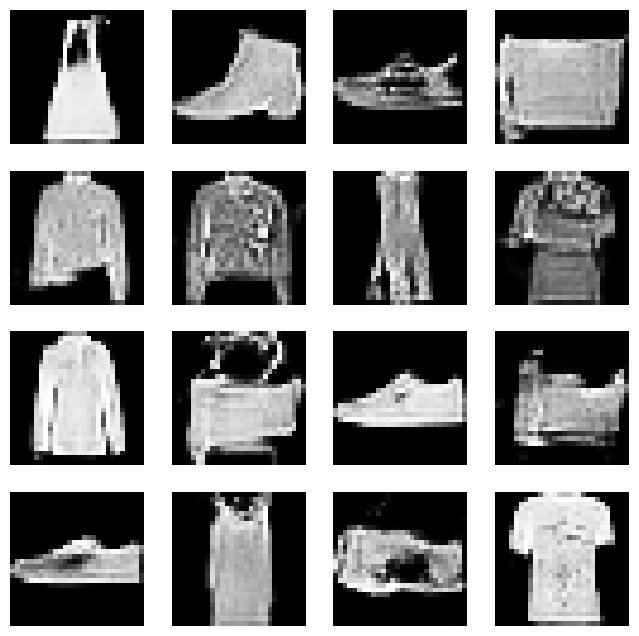

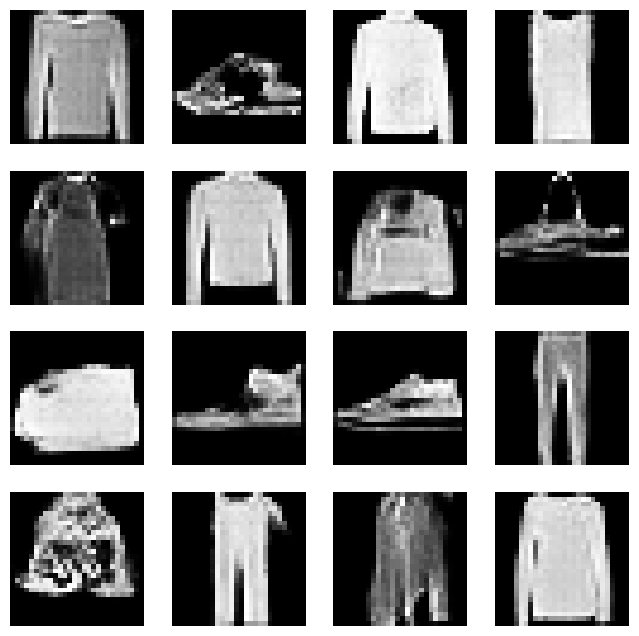

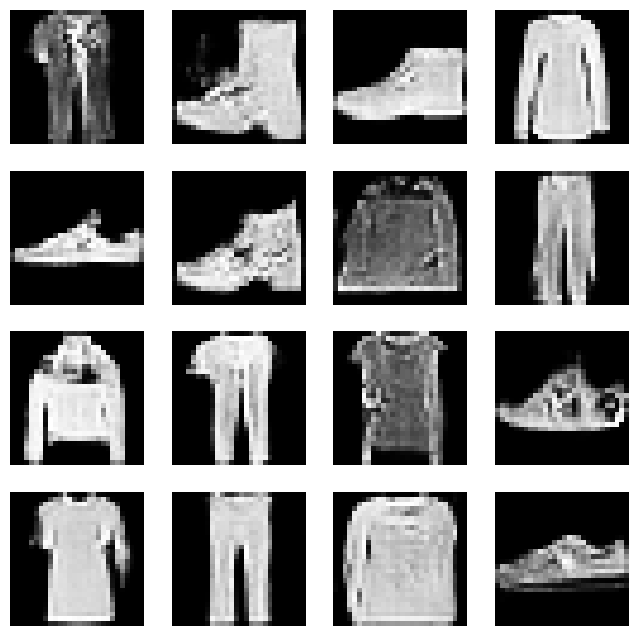

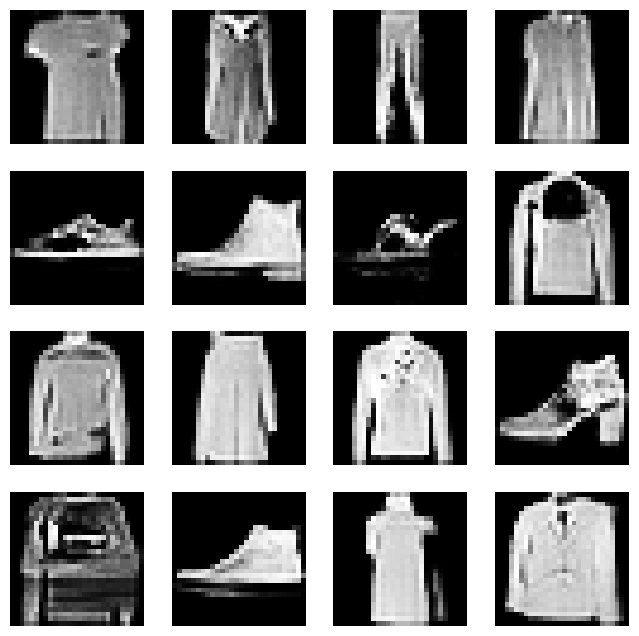

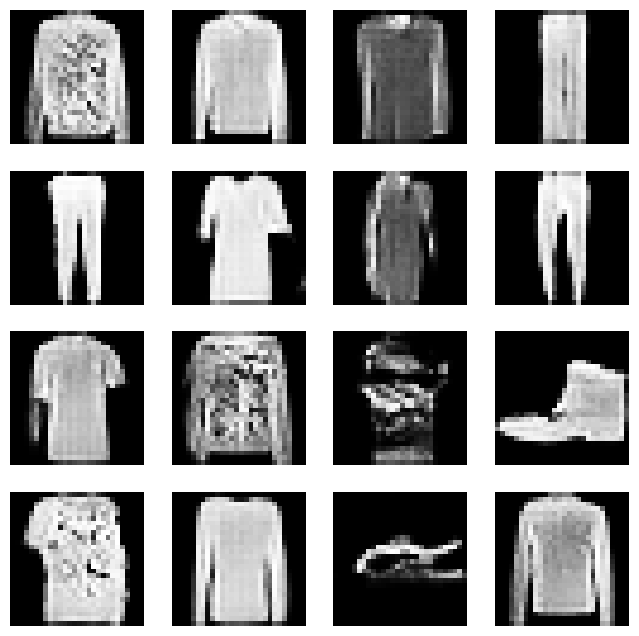

In [29]:
for epoch in range(epochs):
    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

    print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}')

    if (epoch + 1) % 10 == 0:
        generate_images(generator, epoch+1, seed=tf.random.normal([16, latent_dim]))